# Decoding Quantum Hypergraph Product Codes

In this experiment, we will test our decoder on a special type of QLDPC codes called hypergraph product codes. They are also sometimes called Tillich-Zemor product codes. Further information about these codes can be obtained at https://errorcorrectionzoo.org/c/hypergraph_product The particular codes we will play with are constructed from two [4,3] classical random linear codes.

In [1]:
import sys

sys.path.append("../")
sys.path.append("../..")

import numpy as np
import qecstruct as qec
import qecsim.paulitools as pt
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import FuncFormatter, FormatStrFormatter
from tqdm import tqdm
from scipy.stats import sem

from mdopt.mps.utils import create_custom_product_state
from mdopt.contractor.contractor import mps_mpo_contract
from mdopt.optimiser.utils import (
    SWAP,
    COPY_LEFT,
    XOR_BULK,
    XOR_LEFT,
    XOR_RIGHT,
)

from examples.decoding.decoding import (
    css_code_checks,
    css_code_logicals,
    css_code_logicals_sites,
    css_code_constraint_sites,
    apply_constraints,
    apply_bitflip_bias,
    apply_depolarising_bias,
    decode_custom,
    pauli_to_mps,
    decode_css,
    css_code_stabilisers,
    multiply_pauli_strings,
    map_distribution_to_pauli,
    generate_pauli_error_string,
)
from examples.decoding.visualisation import plot_parity_check_mpo

In [2]:
NUM_EXPERIMENTS = 2
SEED = 123
errors = {}
failures_statistics = {}
code_parameters = {}

system_sizes = [4, 8]
error_rates = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
max_bond_dims = [10]

for NUM_BITS in system_sizes:
    CHECK_DEGREE, BIT_DEGREE = 4, 3
    NUM_CHECKS = int(NUM_BITS * BIT_DEGREE / CHECK_DEGREE)
    if NUM_BITS / NUM_CHECKS != CHECK_DEGREE / BIT_DEGREE:
        raise ValueError("The Tanner graph of the code must be bipartite.")

    seed_seq = np.random.SeedSequence(SEED)

    classical_code = qec.random_regular_code(
        NUM_BITS, NUM_CHECKS, BIT_DEGREE, CHECK_DEGREE, qec.Rng(SEED)
    )
    qhgp_code = qec.hypergraph_product(classical_code, classical_code)

    code_parameters[NUM_BITS] = (
        len(css_code_stabilisers(qhgp_code)[0][0]),
        len(qhgp_code) - qhgp_code.num_x_stabs() - qhgp_code.num_z_stabs(),
    )

    for ERROR_RATE in error_rates:
        errors[NUM_BITS, ERROR_RATE] = []
        for l in range(NUM_EXPERIMENTS):
            rng = np.random.default_rng(seed_seq.spawn(1)[0])

            error = generate_pauli_error_string(
                len(qhgp_code),
                ERROR_RATE,
                rng=rng,
                error_model="Bitflip",
            )
            errors[NUM_BITS, ERROR_RATE].append(error)

    for CHI_MAX in max_bond_dims:
        print(f"CHI_MAX = {CHI_MAX}")
        for ERROR_RATE in tqdm(error_rates):
            failures = []

            for l in range(NUM_EXPERIMENTS):
                error = errors[NUM_BITS, ERROR_RATE][l]
                try:
                    _, success = decode_css(
                        code=qhgp_code,
                        error=error,
                        chi_max=CHI_MAX,
                        multiply_by_stabiliser=False,
                        bias_type="Bitflip",
                        bias_prob=0.1,
                        tolerance=0,
                        cut=0,
                        renormalise=True,
                        silent=True,
                        contraction_strategy="Optimised",
                        optimiser="Dephasing DMRG",
                        num_runs=1,
                    )
                    failures.append(1 - success)
                except Exception as e:
                    print(f"Error: {e}")
                    failures.append(np.nan)

            failures_statistics[NUM_BITS, CHI_MAX, ERROR_RATE] = failures

CHI_MAX = 10


100%|██████████| 6/6 [00:22<00:00,  3.75s/it]


CHI_MAX = 10


100%|██████████| 6/6 [01:15<00:00, 12.56s/it]


In [3]:
failure_rates = {}
error_bars = {}

for NUM_BITS in system_sizes:
    for CHI_MAX in max_bond_dims:
        for ERROR_RATE in error_rates:
            failure_rates[NUM_BITS, CHI_MAX, ERROR_RATE] = np.nanmean(
                failures_statistics[NUM_BITS, CHI_MAX, ERROR_RATE]
            )
            error_bars[NUM_BITS, CHI_MAX, ERROR_RATE] = sem(
                failures_statistics[NUM_BITS, CHI_MAX, ERROR_RATE],
                nan_policy="omit",
            )

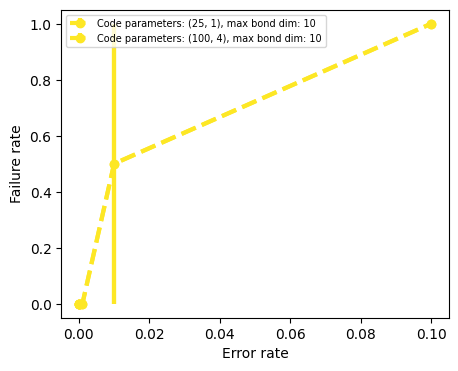

In [4]:
plt.figure(figsize=(5, 4))

green_cmap = colormaps["viridis_r"]
norm = Normalize(vmin=0, vmax=len(max_bond_dims) - 1)

for NUM_BITS in system_sizes:
    for index, CHI_MAX in enumerate(max_bond_dims):
        plt.errorbar(
            error_rates,
            [
                failure_rates[NUM_BITS, CHI_MAX, ERROR_RATE]
                for ERROR_RATE in error_rates
            ],
            yerr=[
                error_bars[NUM_BITS, CHI_MAX, ERROR_RATE] for ERROR_RATE in error_rates
            ],
            fmt="o--",
            label=f"Code parameters: {code_parameters[NUM_BITS]}, max bond dim: {CHI_MAX}",
            linewidth=3,
            color=green_cmap(norm(index)),
        )

    plt.legend(fontsize=7)
    plt.xlabel("Error rate")
    plt.ylabel("Failure rate")
    # plt.yscale("log")
    plt.grid()
plt.show()